In [33]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.grammar_dependency import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

import meshcat
import meshcat.geometry as meshcat_geom

Generating from folder  sink/plates_cups_and_bowls/plates
sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring :  <class 'spatial_scene_grammars_examples.dish_bin.grammar_dependency.sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring'>
sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado :  <class 'spatial_scene_grammars_examples.dish_bin.grammar_dependency.sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado'>
sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise :  <class 'spatial_scene_grammars_examples.dish_bin.grammar_dependency.sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise'>
sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise :  <class 'spatial_scene_grammars_examples.dish_bin.grammar_dependency.sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise'>
Generating from folder  sink/plates_cups_and_bowls/cups
sink:plates_cups_and_bowls:cup

In [34]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

Meshcat url:  http://127.0.0.1:7001/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [35]:
# Convert dataset to observed node sets (caching output) and draw a few examples.

RECONVERT_DATASET = True
DATASET_YAML_FILE = "sink/saved_scenes.yaml"
DATASET_SAVE_FILE = "observed_node_sets.dat"
#DATASET_YAML_FILE = "sink/saved_outlier_scenes.yaml"
#DATASET_SAVE_FILE = "observed_outlier_node_sets.dat"

if RECONVERT_DATASET or not os.path.exists(DATASET_SAVE_FILE):
    type_map = {
        "bin": DishBin
    }
    model_map = {
    }
    for model_type_set in [PlateModels, CupModels, BowlModels]:
        for model_type in model_type_set:
            # Have to cut off the "sink" folder to match model names;
            # dataset management is ugly and should get reorganized...
            model_map[os.path.join(*model_type.sdf.split("/")[1:])] = model_type
    observed_node_sets = convert_scenes_yaml_to_observed_nodes(DATASET_YAML_FILE, type_map, model_map)
    print("Saving...")
    with open(DATASET_SAVE_FILE, "wb") as f:
        pickle.dump(observed_node_sets, f)

print("Loading...")
with open(DATASET_SAVE_FILE, "rb") as f:
    observed_node_sets = pickle.load(f)

example_observed_set = observed_node_sets[1]
draw_scene_tree_contents_meshcat(
    SceneTree.make_from_observed_nodes(example_observed_set),
    zmq_url=vis.window.zmq_url, prefix="observed/contents"
)

Saving...
Loading...


In [16]:
# Draw a random sample from the grammar with its initial params and visualize it.
#torch.random.manual_seed(5)

grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)

supertree = grammar.make_super_tree(max_recursion_depth=10)
print("Supertree size ", len(supertree.nodes))


pyro.set_rng_seed(43)
sampled_tree = grammar.sample_tree(detach=True)
observed_nodes = sampled_tree.get_observed_nodes()

vis["sample"].delete()
draw_scene_tree_contents_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="sample/contents")
draw_scene_tree_structure_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="sample/structure", node_sphere_size=0.01)

Supertree size  625


Super tree has 625 nodes


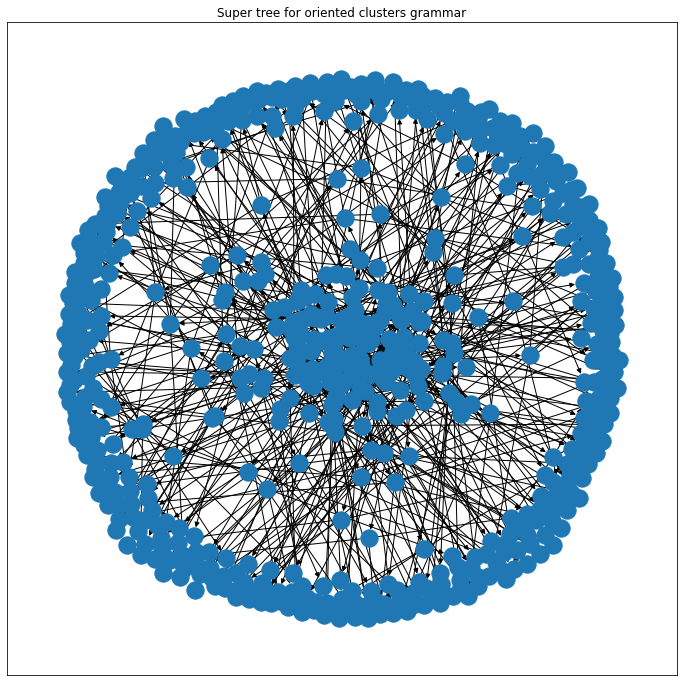

In [42]:
# Draw supertree for this grammar
super_tree = grammar.make_super_tree(max_recursion_depth=10)
plt.figure().set_size_inches(12, 12)
nx.draw_networkx(super_tree, with_labels=False)
plt.title("Super tree for oriented clusters grammar")
print("Super tree has %d nodes" % len(list(super_tree.nodes)))


In [43]:
print([o.translation for o in example_observed_set])

[tensor([0.5018, 0.3454, 0.1099]), tensor([ 0.3969, -0.1448,  0.0600]), tensor([ 0.4459, -0.1417,  0.0166]), tensor([ 0.4611, -0.1315,  0.1563]), tensor([0.5000, 0.0000, 0.0000])]


In [44]:
# Parse an example scene.
trees = get_optimized_trees_from_mip_results(infer_mle_tree_with_mip(grammar, example_observed_set, N_solutions=6, max_recursion_depth=10, verbose=True))
vis["parses"].delete()
draw_scene_tree_contents_meshcat(trees[0], zmq_url=vis.window.zmq_url, prefix="parses/contents")
for k, tree in enumerate(trees[:]):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/structure/%d_%f" % (k, tree.score()), node_sphere_size=0.025, with_triad=False, alpha=0.5)

Starting setup.
Activation vars allocated.
Equivalent sets:  43 43
Continuous variables and SO(3) constraints allocated for all equivalence sets.
Setup time:  1.0512561798095703
Num vars:  2636
Num constraints:  10516
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Sat Oct 30 01:35:27 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 9630 rows, 2636 columns and 33691 nonzeros
Model fingerprint: 0xde0fa98a
Model has 126 quadratic objective terms
Variable types: 1842 continuous, 794 integer (794 binary)
Coefficient statistics:
  Matrix range     [5e-03, 2e+01]
  Objective range  [1e-02, 3e+00]
  QObjective range [5e+01, 4e+02]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 5794 rows and 1247 columns
Presolve time: 0.12s
Presolved: 3836 rows, 1389 columns, 16817 nonzeros
Presolved model has 118 quadratic objective terms
Variable types: 1356 continuous, 33 integer (33 binary)

Root relax

# MIPMAP

In [8]:
em = EMWrapper(grammar, observed_node_sets)
# Multiprocessing is unstable on this machine; going the slow road...
em.do_iterated_em_fitting(em_iterations=20, tqdm=tqdm, N_solutions=10, num_workers=10, max_recursion_depth=10)

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (Object): ConstrainedParameter()
    (TerminalObject): ConstrainedParameter()
    (MaybeObjectsInBowl): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow): None
    (Plate): None
    (sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White): None
    (ObjectsOnPlate): ConstrainedParameter()
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado): None
    (sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue): None
    (sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise): None
    (DishBin): ConstrainedParameter()
    (sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose): None
    (Bowl): None
    (TerminalCup): ConstrainedParameter()
    (ObjectsInBowl): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue): None
    (sink:plates_cups_and_bowls:plates:Thres

In [15]:
# Save our grammar params and the history object
torch.save(grammar.state_dict(), "fit_grammar.torch")
with open("fitting_history.pickle", "wb") as f:
    pickle.dump(em, f)

In [4]:
# Reload
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
#grammar.load_state_dict(torch.load("fit_grammar.torch"))
with open("fitting_history.pickle", "rb") as f:
    em = pickle.load(f)

Dish bin geometric parameter
Final params:  tensor([0.3432])
mean tensor([[ 0.0000,  0.0000,  0.0500],
        [-0.0045,  0.0446,  0.0581],
        [-0.0034,  0.0411,  0.0572],
        [-0.0041,  0.0416,  0.0580],
        [-0.0056,  0.0418,  0.0591],
        [-0.0064,  0.0418,  0.0598],
        [-0.0069,  0.0418,  0.0604],
        [-0.0074,  0.0418,  0.0610],
        [-0.0078,  0.0422,  0.0615],
        [-0.0080,  0.0424,  0.0619],
        [-0.0081,  0.0427,  0.0621],
        [-0.0083,  0.0430,  0.0624],
        [-0.0084,  0.0433,  0.0626],
        [-0.0085,  0.0436,  0.0629],
        [-0.0086,  0.0439,  0.0631],
        [-0.0087,  0.0440,  0.0633],
        [-0.0087,  0.0440,  0.0635],
        [-0.0086,  0.0439,  0.0637],
        [-0.0086,  0.0435,  0.0640],
        [-0.0087,  0.0426,  0.0648],
        [-0.0084,  0.0428,  0.0660]])
0:xyz:mean final: tensor([-0.0084,  0.0428,  0.0660])
variance tensor([[0.0500, 0.0500, 0.0500],
        [0.0069, 0.0277, 0.0023],
        [0.0069, 0.0276, 

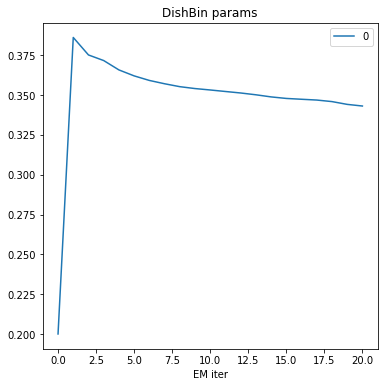

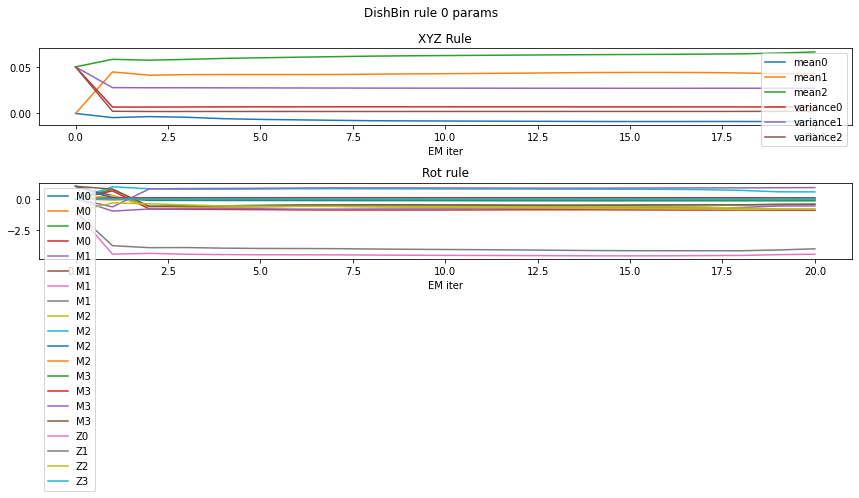

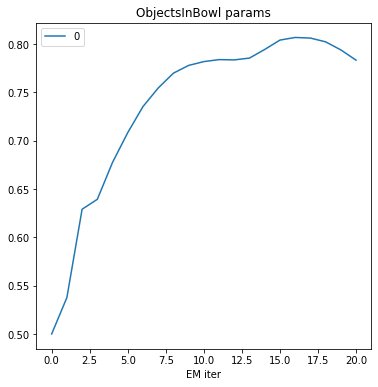

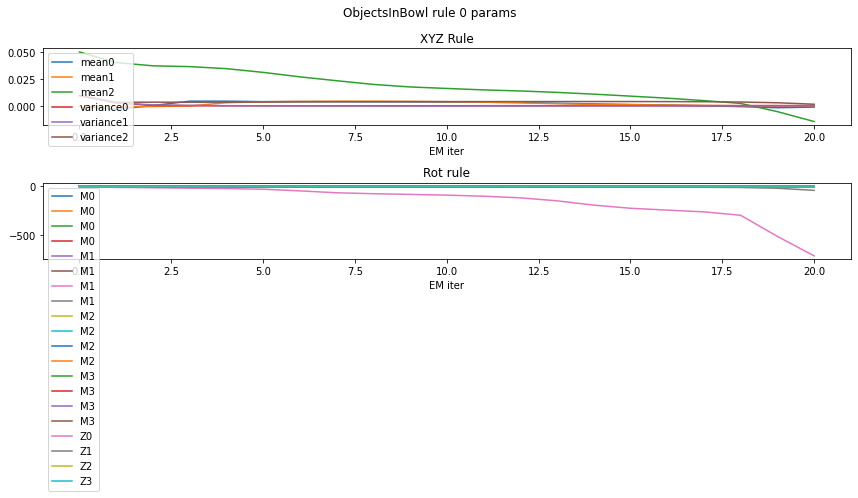

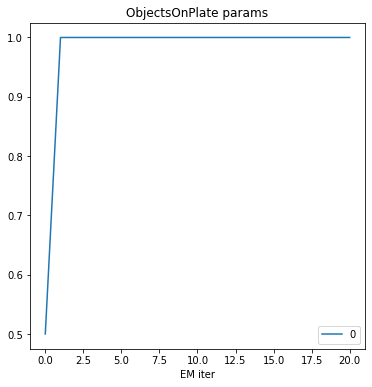

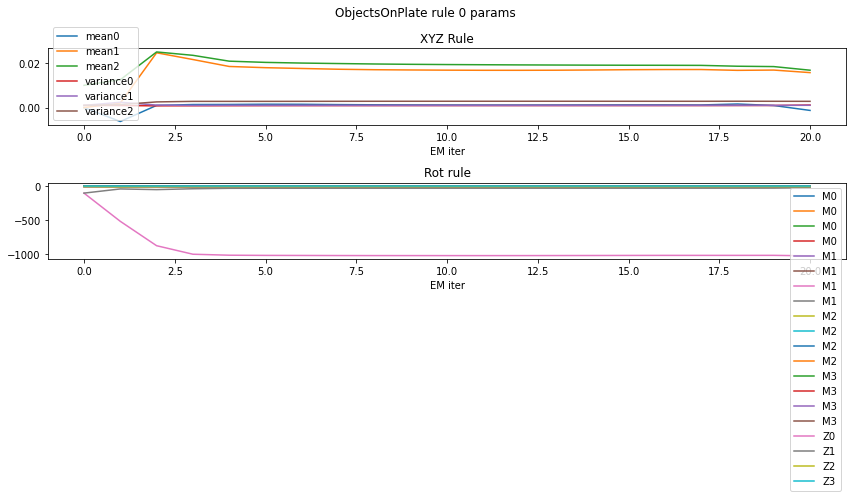

In [24]:
print("Dish bin geometric parameter")
em.plot_grammar_parameter_history(DishBin)
print("Objects in bowl")
em.plot_grammar_parameter_history(ObjectsInBowl)
print("Objects on plate")
em.plot_grammar_parameter_history(ObjectsOnPlate)

Text(0.5, 1.0, 'p(O) across EM iterations')

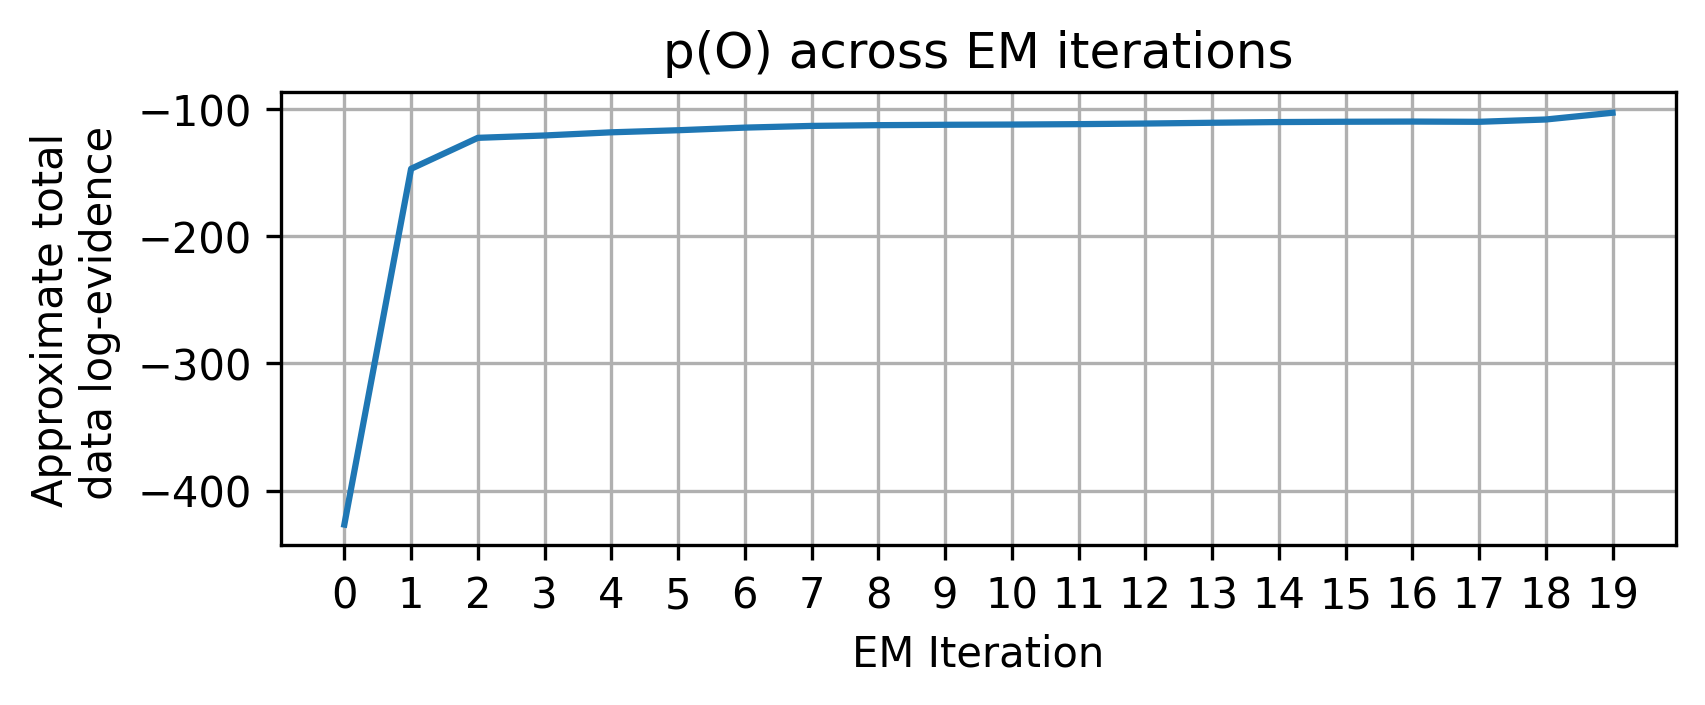

In [25]:
# Plot (approx) log-evidence over training
sum_evidences = [sum(e) for e in em.log_evidence_iters]
plt.figure(dpi=300).set_size_inches(6, 2)
#for k, e in enumerate(em.log_evidence_iters):
#    plt.scatter(np.repeat([k], len(e)), e)
#for k in range(len(em.log_evidence_iters[0])):
#    plt.plot([e[k] for e in em.log_evidence_iters], alpha=0.25, linestyle='-')
#parts = plt.violinplot(
#    em.log_evidence_iters,
#    showmeans=True,
#    showextrema=True,
#    quantiles=[[0.25, 0.75] for k in range(len(mean_evidences))],
#    positions=range(len(mean_evidences))
#)
plt.plot(sum_evidences, c=parts["bodies"][0].get_facecolor()[0], alpha=1.0)

plt.ylabel("Approximate total\n data log-evidence")
plt.xlabel("EM Iteration")
plt.grid(True)
plt.xticks(range(len(em.log_evidence_iters)));
plt.title("p(O) across EM iterations")

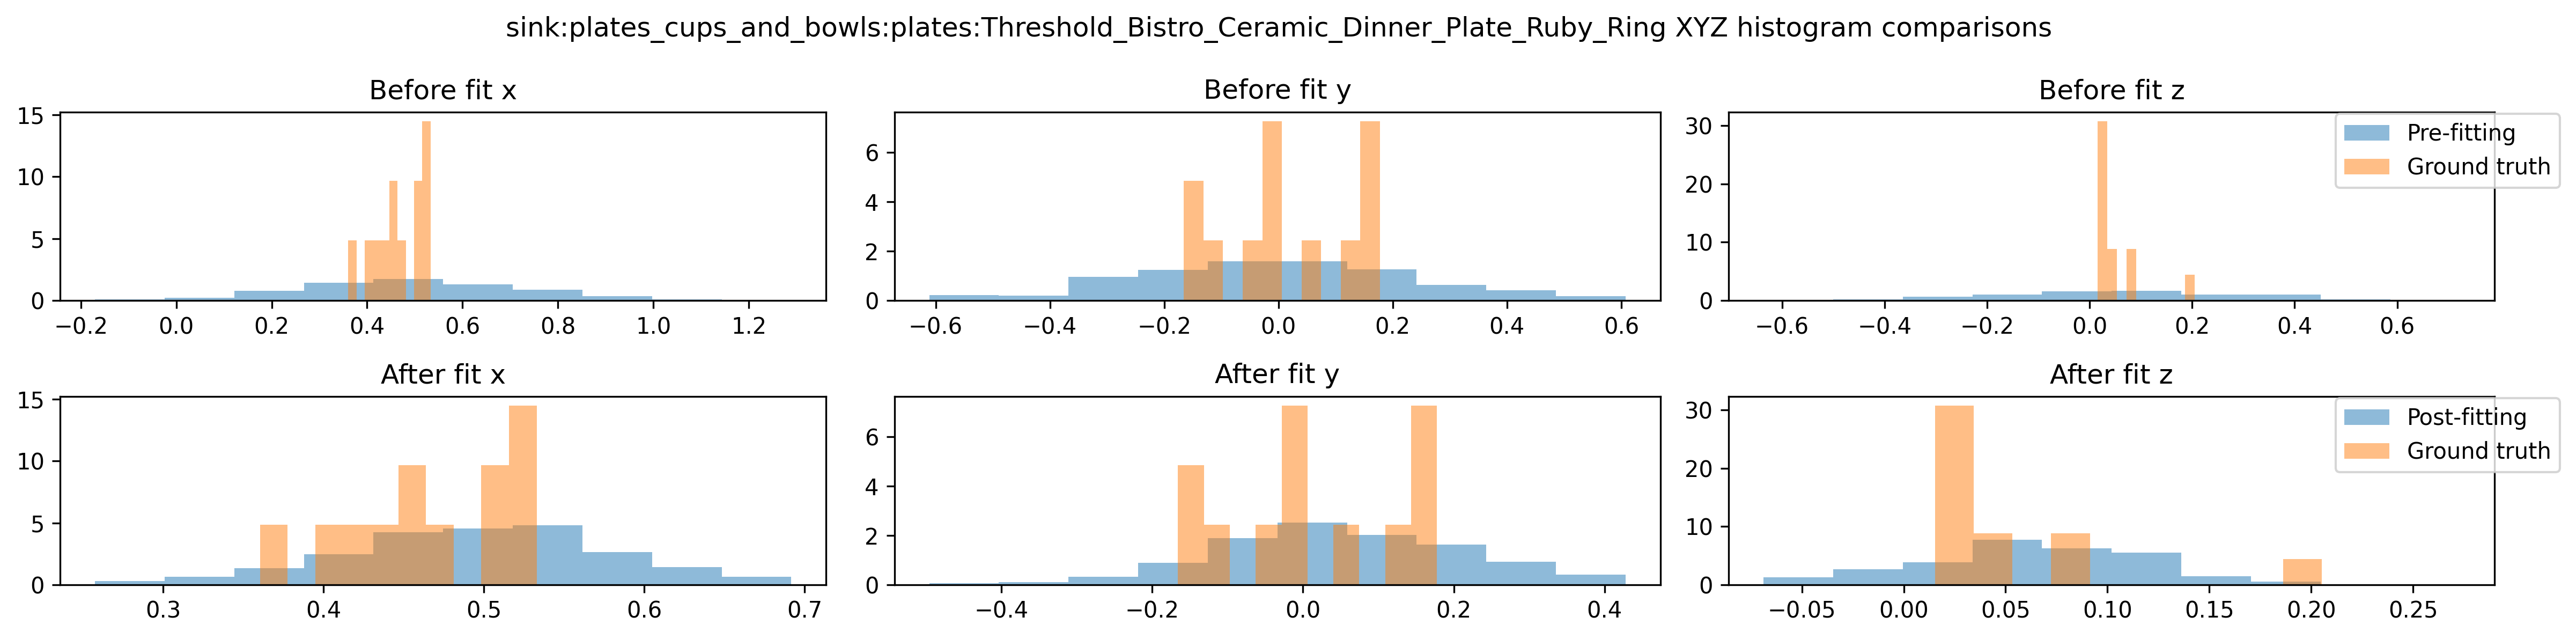

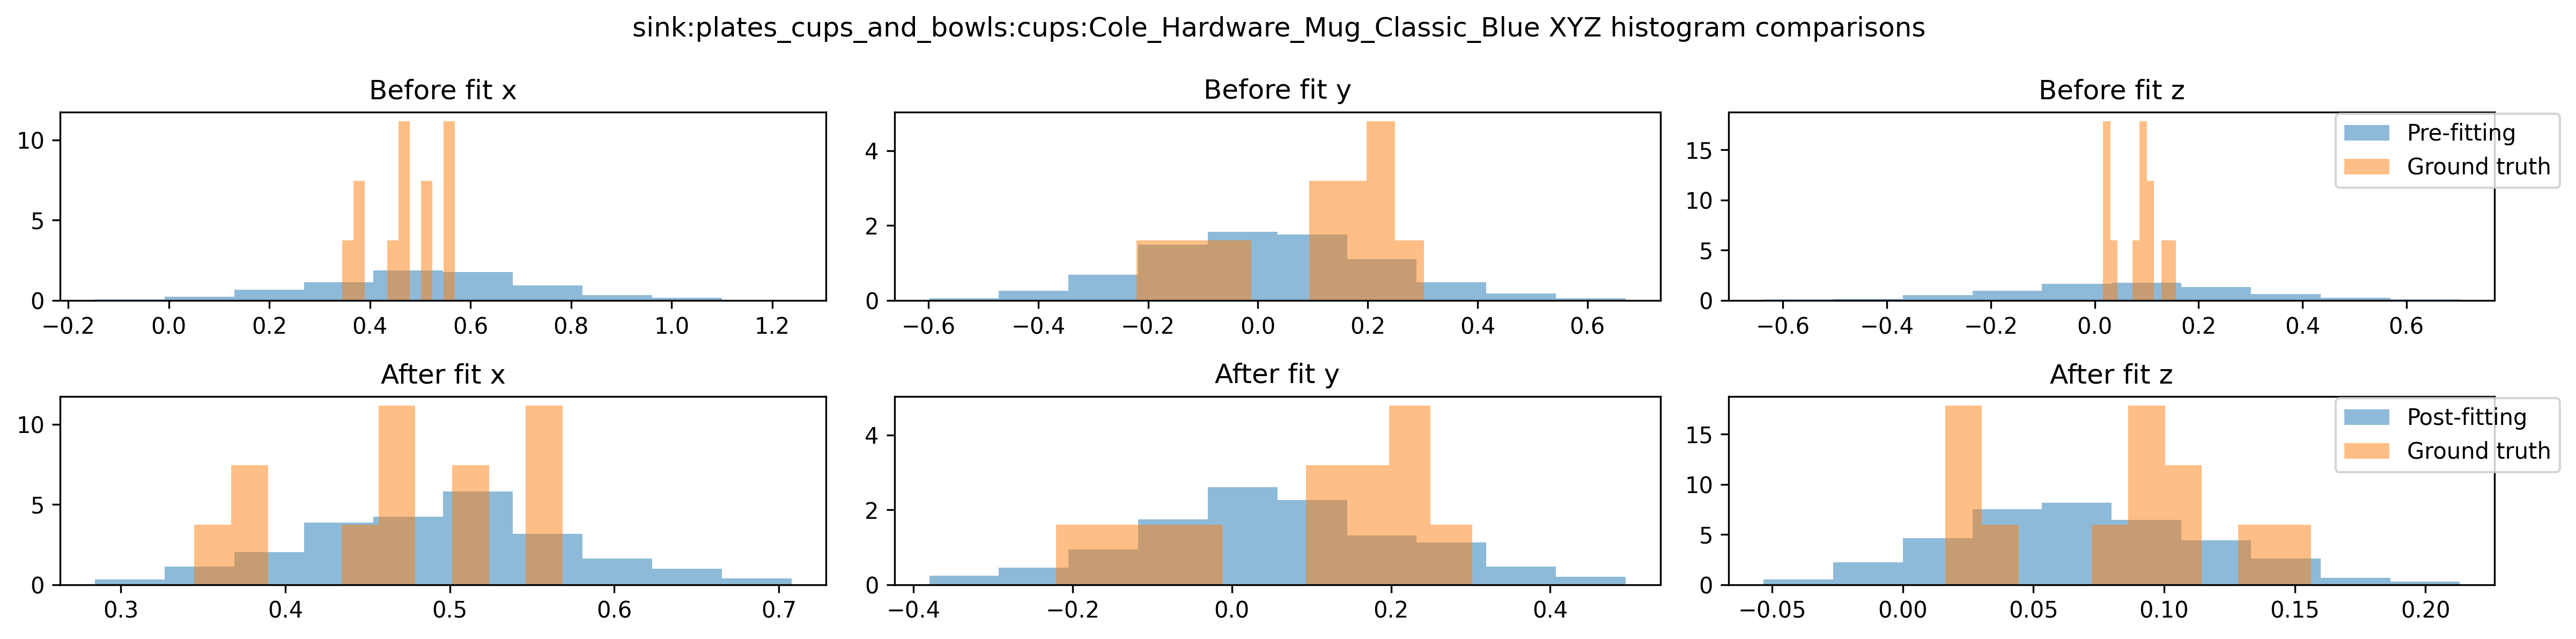

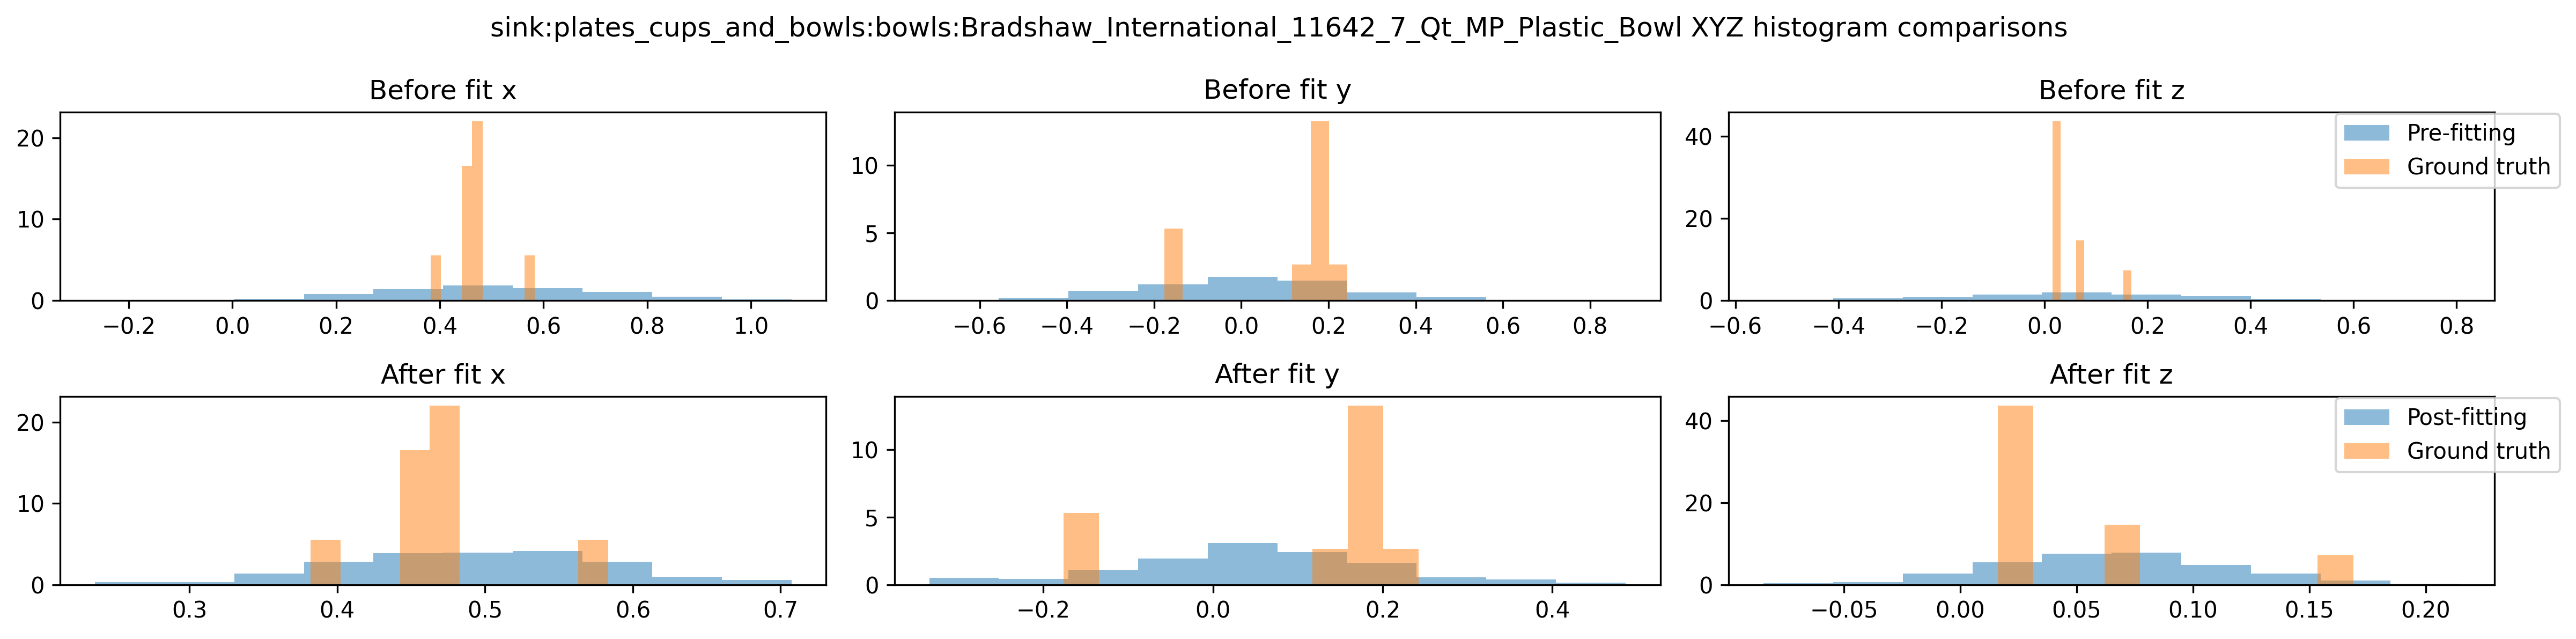

In [26]:
def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)
def plot_post_fit_tree_samples(em, N_samples=100):
    pre_fit_samples= []
    em.grammar.load_state_dict(em.grammar_iters[0])
    for k in range(N_samples):
        pre_fit_samples.append(em.grammar.sample_tree(detach=True))
    fit_samples = []
    em.grammar.load_state_dict(em.grammar_iters[-1])
    for k in range(N_samples):
        fit_samples.append(em.grammar.sample_tree(detach=True))

    for node_type in [PlateModels[0], CupModels[0], BowlModels[0]]:
        plt.figure(dpi=300).set_size_inches(16, 4)
        plt.suptitle("%s XYZ histogram comparisons" % node_type.__name__)

        gt_l = get_all_node_xyzs([SceneTree.make_from_observed_nodes(sample) for sample in observed_node_sets], node_type)
        fit_l = get_all_node_xyzs([sample for sample in fit_samples], node_type)
        pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], node_type)
        # Pre fit
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.title("Before fit %s" % "xyz"[k:(k+1)])
            plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))

        for k in range(3):
            plt.subplot(2, 3, k+1+3)
            plt.title("After fit %s" % "xyz"[k:(k+1)])
            plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
plot_post_fit_tree_samples(em, N_samples=1000)

In [27]:
# Draw some samples from the fit posterior
vis["fit_samples"].delete()
for k in range(5):
    tree = grammar.sample_tree(detach=True)
    draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/contents" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/structure" % k, )

In [41]:
# Parse observed scenes.

# Reload
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
#grammar.load_state_dict(torch.load("fit_grammar.torch"))
with open("fitting_history.pickle", "rb") as f:
    em = pickle.load(f)
    
with open("observed_outlier_node_sets.dat", "rb") as f:
    observed_node_sets_outliers = pickle.load(f)
    
    
#example_observed_set = observed_node_sets_outliers[2]
example_observed_set = observed_node_sets[1]
vis["observed"].delete()
draw_scene_tree_contents_meshcat(
    SceneTree.make_from_observed_nodes(example_observed_set),
    zmq_url=vis.window.zmq_url, prefix="observed/contents"
)

trees = get_optimized_trees_from_mip_results(infer_mle_tree_with_mip(grammar, example_observed_set, N_solutions=5, max_recursion_depth=10, verbose=True))
vis["parses"].delete()
draw_scene_tree_contents_meshcat(trees[0], zmq_url=vis.window.zmq_url, prefix="parses/contents")
for k, tree in enumerate(trees[:1]):
    draw_scene_tree_structure_meshcat(
        tree, zmq_url=vis.window.zmq_url,
        prefix="parses/structure/%d_%f" % (k, tree.score()),
        node_sphere_size=0.025, with_triad=False, alpha=0.25,
        linewidth=20,
        color_by_score=None)#(-5., 5.))

Starting setup.
Activation vars allocated.
Continuous variables and SO(3) constraints allocated for all equivalence sets.
Setup time:  1.1259973049163818
Num vars:  2636
Num constraints:  10516
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Fri Oct 29 18:17:22 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 9630 rows, 2636 columns and 33691 nonzeros
Model fingerprint: 0xc4bb2c73
Model has 126 quadratic objective terms
Variable types: 1842 continuous, 794 integer (794 binary)
Coefficient statistics:
  Matrix range     [5e-03, 2e+01]
  Objective range  [1e-02, 3e+00]
  QObjective range [5e+01, 4e+02]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 5794 rows and 1247 columns
Presolve time: 0.12s
Presolved: 3836 rows, 1389 columns, 16817 nonzeros
Presolved model has 118 quadratic objective terms
Variable types: 1356 continuous, 33 integer (33 binary)

Root relaxation: objective 7.83378

In [31]:
# Parse all scenes in dataset, and return by best score.
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.

parse_sets, observed_node_times = get_map_trees_for_observed_node_sets(grammar, observed_node_sets, N_solutions=10, num_workers=10, tqdm=tqdm, report_timing=True)
scores = torch.stack(
    [torch.logsumexp(torch.tensor([parse.score() for parse in parses]), dim=0)
     for parses in parse_sets]).detach().numpy()

parse_sets_outliers = get_map_trees_for_observed_node_sets(grammar, observed_node_sets_outliers, N_solutions=10, num_workers=10, tqdm=tqdm)
scores_outliers = torch.stack(
    [torch.logsumexp(torch.tensor([parse.score() for parse in parses]), dim=0)
     for parses in parse_sets_outliers]).detach().numpy()

  0%|          | 0/30 [00:00<?, ?it/s]

Elapsed 7.056793s +/ 2.515391 (min 7.188939, median 2.895318, max 11.699887)


  0%|          | 0/3 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 2, got 0)

Text(0, 0.5, 'Parsing time (s)')

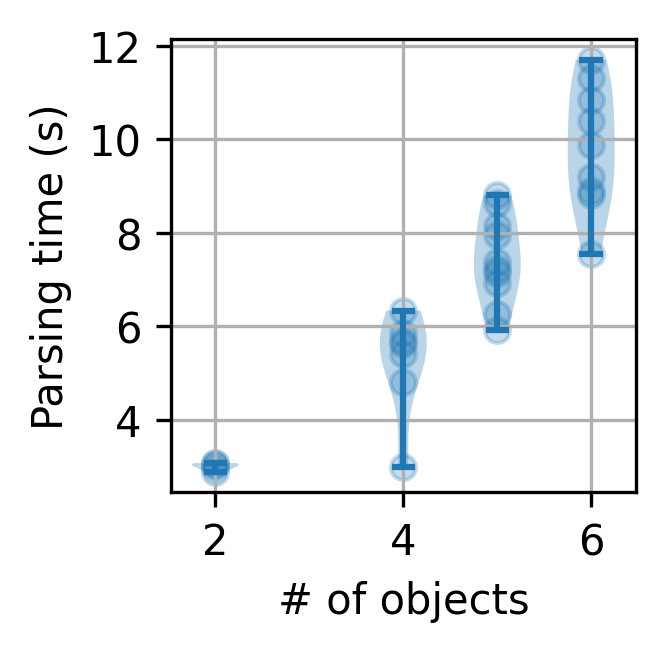

In [51]:
plt.figure(dpi=300).set_size_inches(2, 2)
x = np.array([len(observed_nodes) for observed_nodes in observed_node_sets])
observed_node_times = np.array(observed_node_times)
xs = []
times = []
for env_size in range(1, 10):
    these_times = observed_node_times[x == env_size]
    if len(these_times) > 0:
        xs.append(env_size)
        times.append(these_times)
parts = plt.violinplot(times, positions=xs)
plt.scatter(x, observed_node_times, c=parts["bodies"][0].get_facecolor(), alpha=0.25)
plt.grid(True)
plt.xlabel("# of objects")
plt.ylabel("Parsing time (s)")

In [ ]:
inds_ascending = np.argsort(scores, axis=0)
print("Ranking: ", inds_ascending)
plt.hist(scores, bins=100, label="Training set")
plt.hist(scores_outliers, bins=100, label="Outliers")
plt.xlabel("Log-prob of best parse tree")
plt.ylabel("Occurance in dataset")
plt.legend()
print(parses[-1].score(verbose=True))